In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pyro
assert pyro.__version__.startswith('1.6.0')

In [3]:
import torch
import torch.distributions as td
torch.multiprocessing.set_sharing_strategy('file_system')

In [4]:
import random
import pickle
import numpy as np
from tqdm.auto import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
import arviz

In [5]:
from collections import OrderedDict, namedtuple
from pyro import poutine

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

Reproducibility

In [7]:
random.seed(0)
np.random.seed(0)
pyro.set_rng_seed(0)
torch.manual_seed(0)
rng = np.random.RandomState(0)

# Mixed-Mebership Models

This is a hierarchical mixture model where we induce up to $T$ components of a given family $\mathcal L$, each governed by a parameter sampled from a given prior $\mathcal P$ with parameter $\tau$. We then model $G$ groups, each with $N$ datapoints, which are sampled from a group-specific mixture model. The mixture coeffcients are governed by a Dirichlet Process prior with parameter $\alpha$.

This is the generative story:

\begin{align}
    \text{Draw global parameters}& \\    
    \mu_t &\sim \mathcal P(\tau) & \quad t=1,\ldots, T \\
    \text{Draw group parameters }& \\
    \pi_{g} &\sim \mathrm{DP}(\alpha) & \quad g=1, \ldots, G \\ 
    \text{Draw data points} & \\
    Z_{g,n} & \sim \mathrm{Cat}(\pi_g) &\quad g=1, \ldots, G \quad n=1, \ldots, N\\
    X_{g,n}|Z_{g,n}=t & \sim \mathcal L(\mu_t)\\
\end{align}

To design different models, simply choose
* the prior family and its (fixed) parameter
* the likelihood function 

In [10]:
from probabll.bda.mmm import Plotting

In [11]:
example = 'poisson'

In [12]:
if example == 'poisson':
    S = 10000
    b = rng.poisson(1., size=S)
    groups = np.stack(
        [
            b,
            b,
            rng.poisson(1., size=S), 
            rng.poisson(1., size=S), 
            rng.poisson(5., size=S), 
            np.where(
                rng.uniform(0., 1., size=S) > 0.5, 
                rng.poisson(1., size=S), 
                rng.poisson(5., size=S)
            ),
            np.where(
                rng.uniform(0., 1., size=S) > 0.2, 
                rng.poisson(1., size=S), 
                rng.poisson(7., size=S)
            ),
        ], 
        -1    
    )
else:
    S = 10000
    b = rng.normal(0., 1., size=S)
    groups = np.stack(
        [
            b,
            b,
            rng.normal(0., 1., size=S), 
            rng.normal(0., 1., size=S), 
            rng.normal(0.5, 1., size=S), 
            rng.normal(0., 0.2, size=S), 
            rng.normal(-1., 0.1, size=S), 
            np.where(
                rng.uniform(0., 1., size=S) > 0.5, 
                rng.normal(-1, 1., size=S), 
                rng.normal(1., 1., size=S)
            ),
            np.where(
                rng.uniform(0., 1., size=S) > 0.5, 
                rng.normal(-1, 1., size=S), 
                rng.gamma(5., 5., size=S)
            ),
            np.where(
                rng.uniform(0., 1., size=S) > 0.5, 
                rng.normal(-1, 1., size=S), 
                rng.poisson(10., size=S)
            )
        ], 
        -1    
    )
groups.shape

(10000, 7)

In [13]:
groups.mean(0).min(), groups.mean(0).max(), groups.std(0).min(), groups.std(0).max()

(0.9905, 5.0291, 0.995137573403797, 2.8280924153923697)

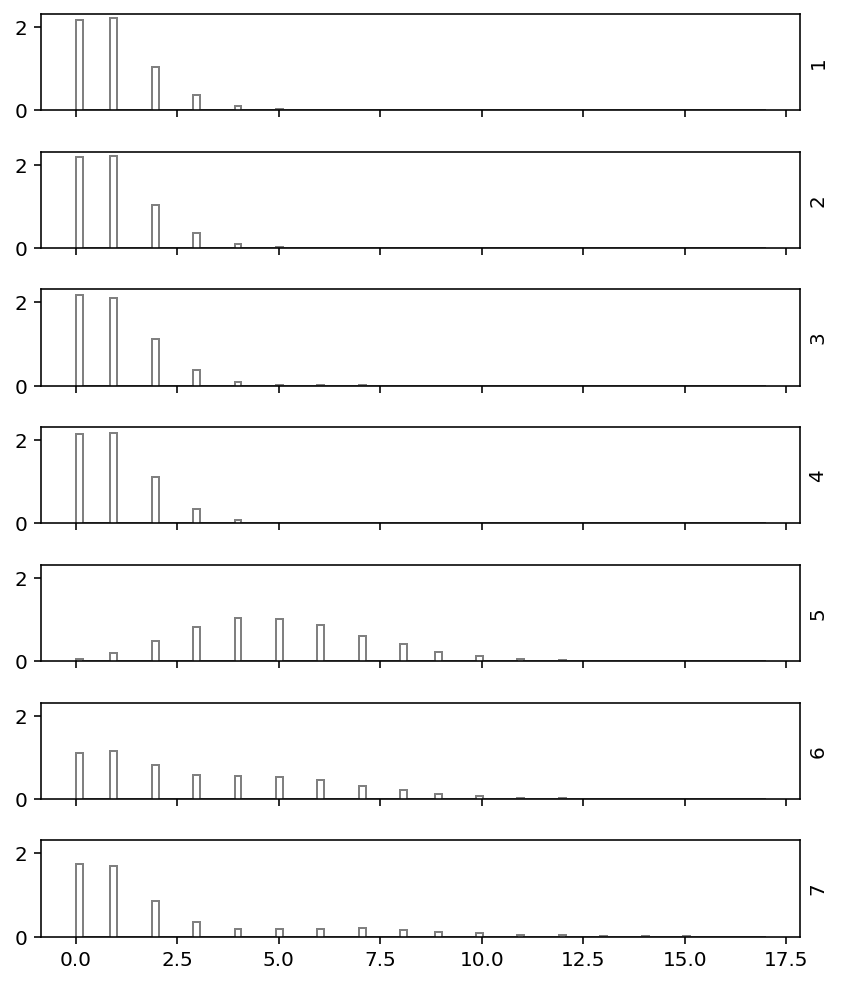

In [14]:
_ = Plotting.obs(groups, sharey='col')

In [15]:
from probabll.bda.mmm import MixedMembershipRD, Family, Plotting

In [16]:
model = MixedMembershipRD(
    Family.Poisson(1., 1., delta=False) if example == 'poisson' else Family.Normal(0., 10, 1.0, 0.1, delta=False),
    T=10, 
    DP_alpha=0.1, 
    device=torch.device('cuda:1')
)

In [17]:
x = model.prepare(groups)
x.shape, x.dtype, x.device

(torch.Size([10000, 7]), torch.float32, device(type='cuda', index=1))

In [18]:
model.print_model_shapes()

    Trace Shapes:                      
     Param Sites:                      
    Sample Sites:                      
  components dist                |     
            value             10 |     
         log_prob                |     
      lambda dist             10 |     
            value             10 |     
         log_prob             10 |     
         DPs dist                |     
            value              7 |     
         log_prob                |     
        beta dist              7 | 9   
            value              7 | 9   
         log_prob              7 |     
       omega dist                | 7 10
            value                | 7 10
         log_prob                |     
      groups dist                |     
            value              7 |     
         log_prob                |     
observations dist                |     
            value          10000 |     
         log_prob                |     
           z dist    10000     7 |     


In [19]:
model.print_guide_shapes()

  Trace Shapes:        
   Param Sites:        
          kappa  7  9  
     lambda_loc    10  
   lambda_scale    10  
  Sample Sites:        
components dist     |  
          value 10  |  
       log_prob     |  
    lambda dist 10  |  
          value 10  |  
       log_prob 10  |  
       DPs dist     |  
          value  7  |  
       log_prob     |  
      beta dist  7  | 9
          value  7  | 9
       log_prob  7  |  


In [20]:
model.prior_checks(x)

OrderedDict([('mean',
              tensor([0.4000, 0.3900, 0.3800, 0.3600, 0.0000, 0.0500, 0.1100],
                     device='cuda:1')),
             ('std',
              tensor([0.3500, 0.3500, 0.3800, 0.3200, 0.0000, 0.0100, 0.0000],
                     device='cuda:1'))])

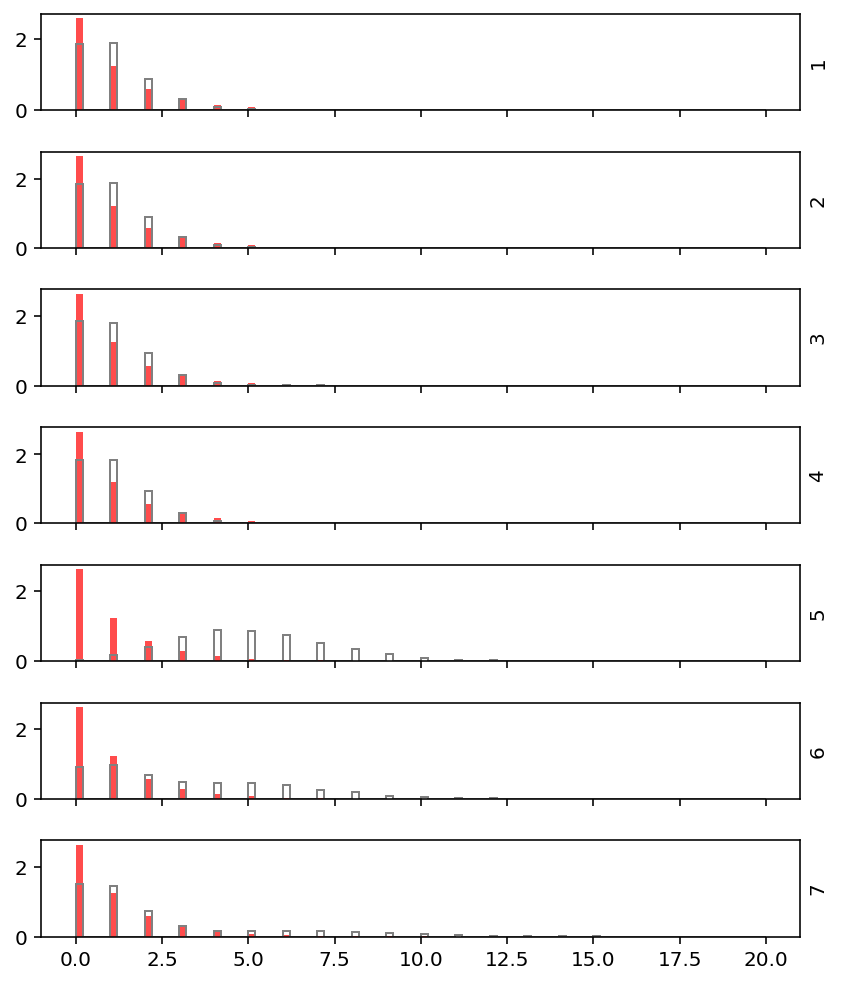

In [21]:
_ = Plotting.obs(groups, model.prior_predict(num_samples=100)['obs'])

In [22]:
model.fit(x, 2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

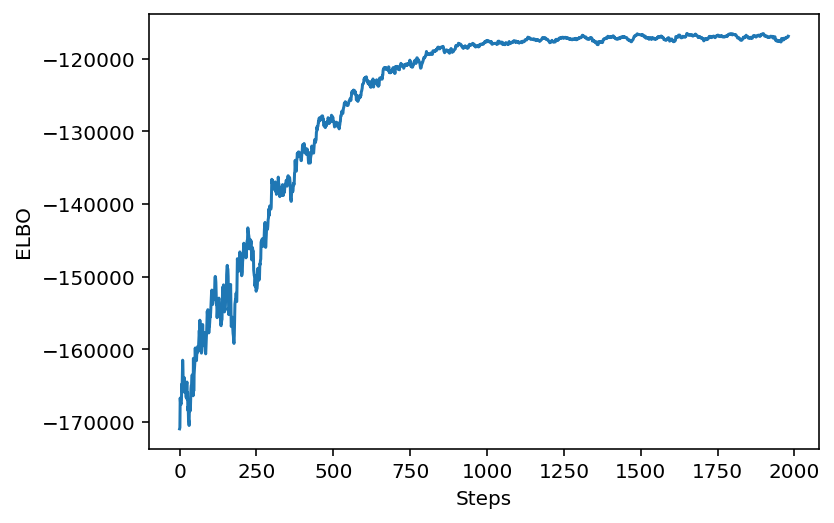

In [23]:
_ = Plotting.elbo(model)

In [24]:
posterior = model.posterior_predict(num_samples=1000)

In [25]:
print(tabulate([[rv_name, rv_t.shape] for rv_name, rv_t in posterior.items()]))

------  -------------------------------
lambda  torch.Size([1000, 1, 10])
beta    torch.Size([1000, 1, 7, 9])
z       torch.Size([1000, 10000, 7])
obs     torch.Size([1000, 10000, 7])
omega   torch.Size([1000, 1, 1, 7, 10])
------  -------------------------------


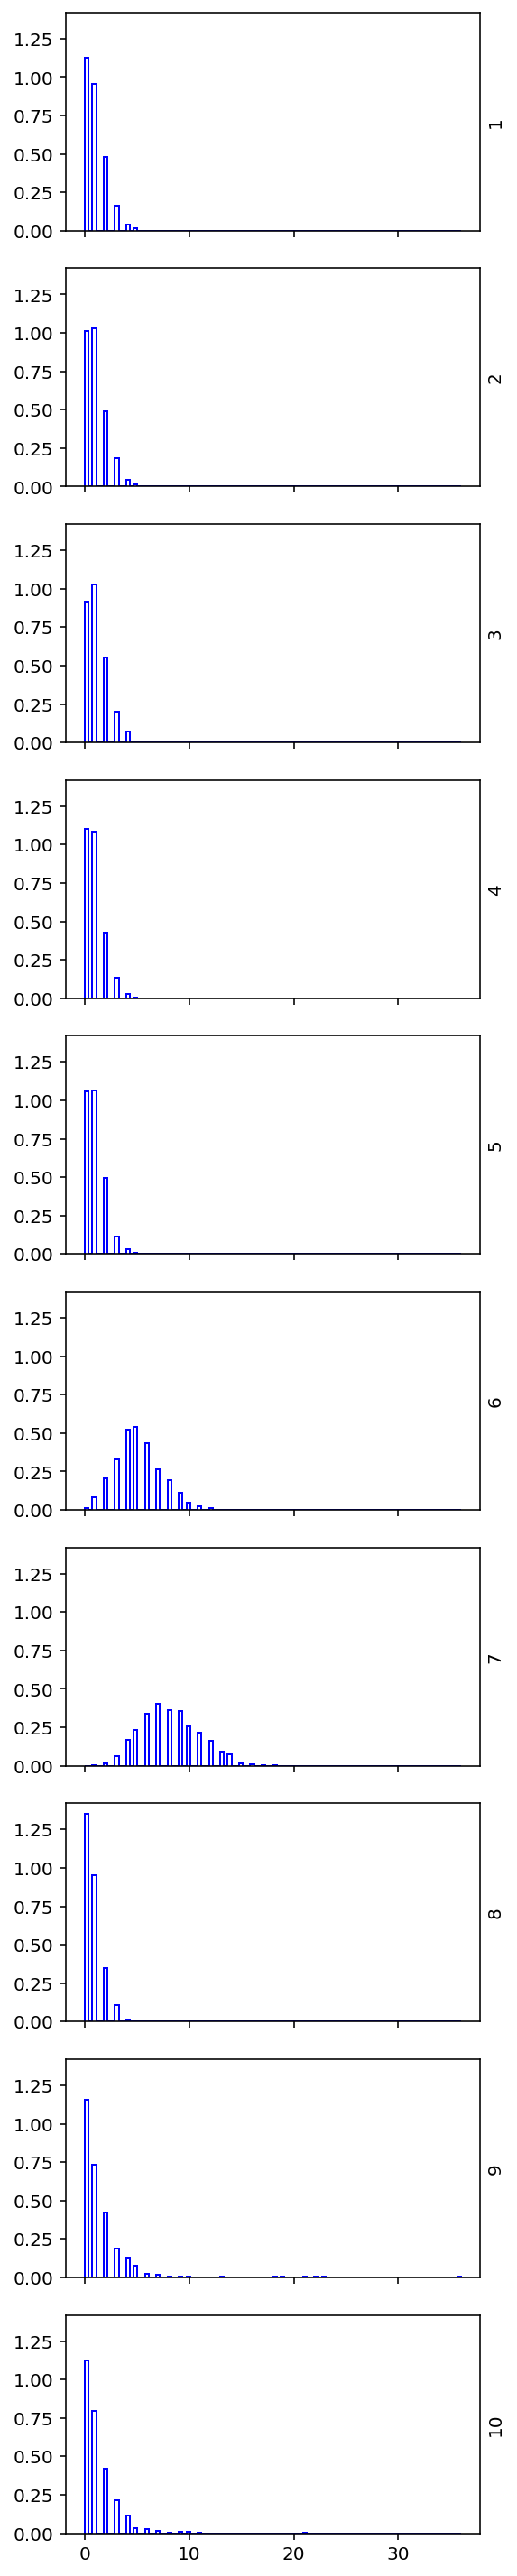

In [26]:
_ = Plotting.components(posterior, model)

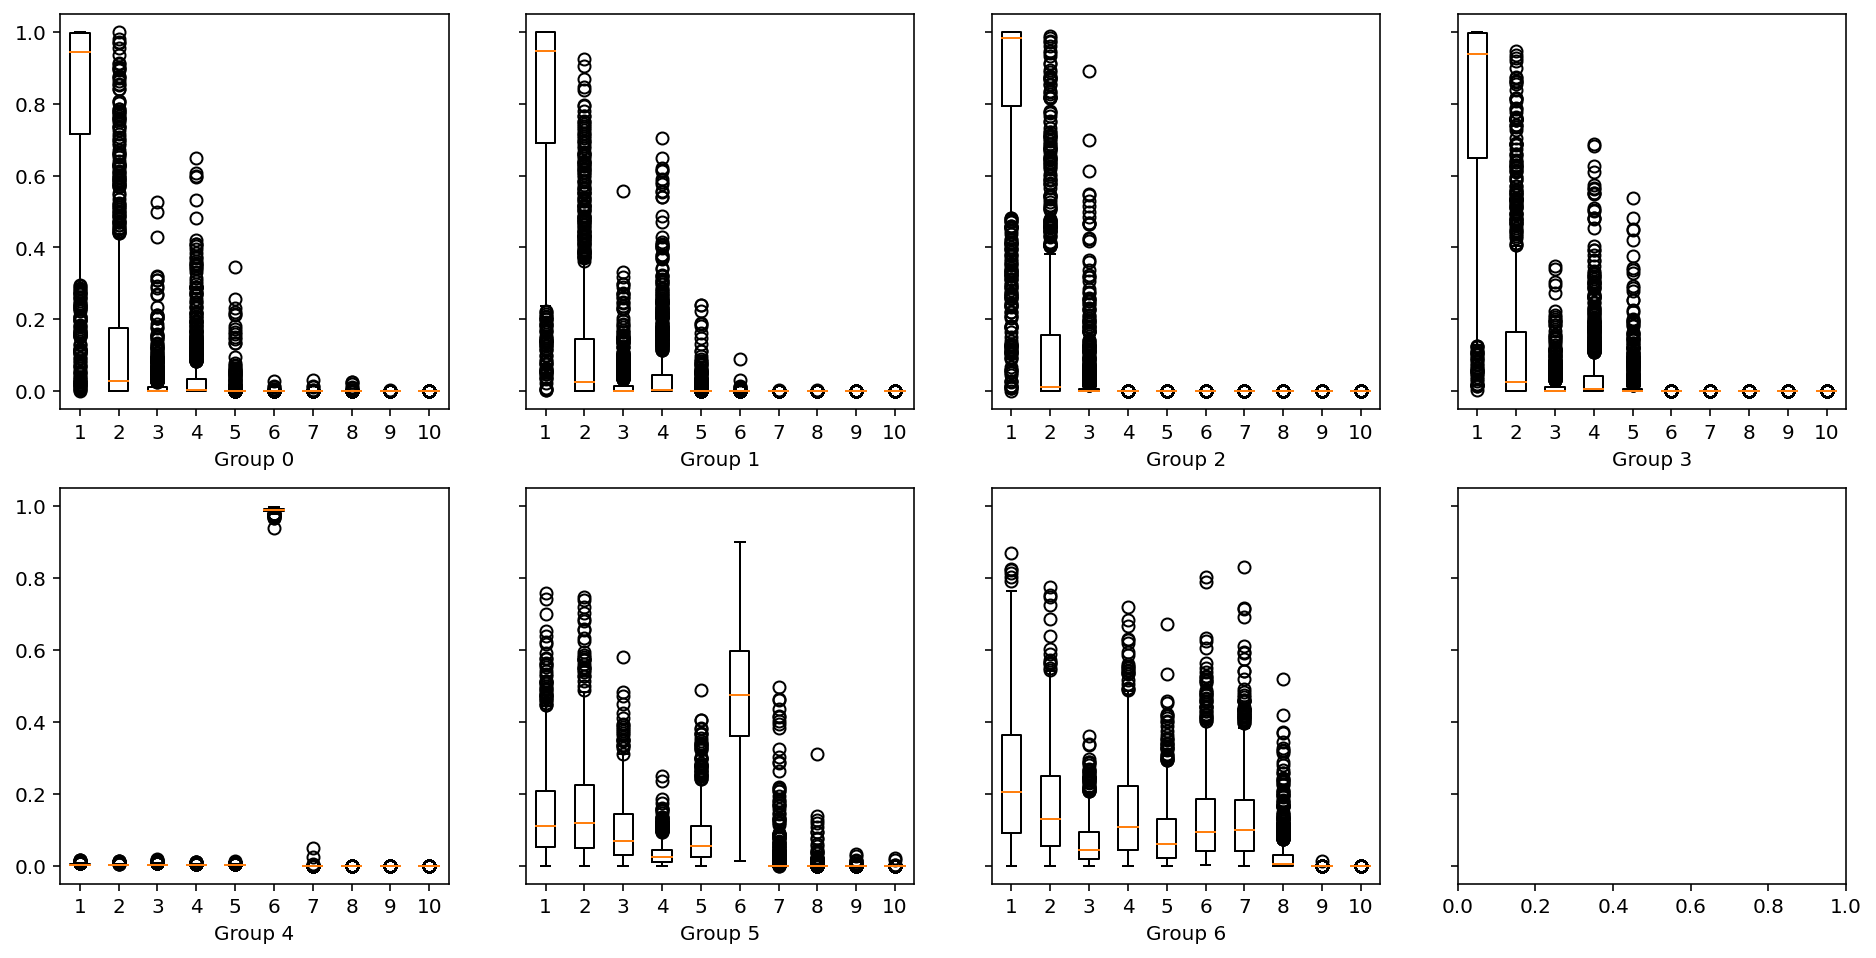

In [27]:
_ = Plotting.mixture_weights(posterior, model, cols=4)

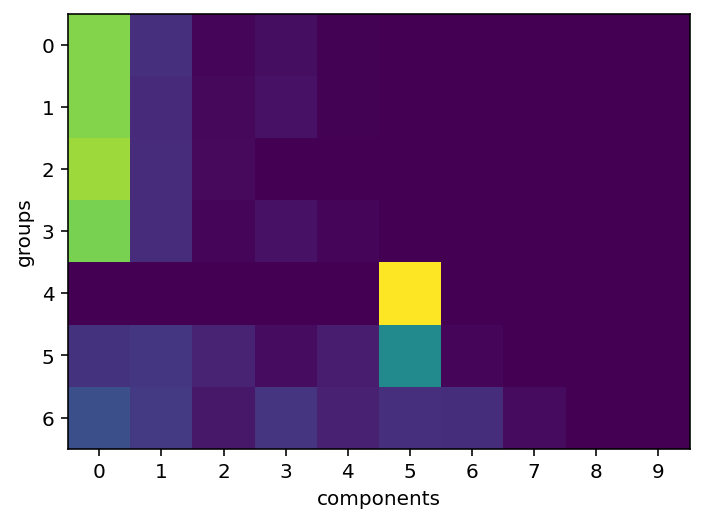

In [28]:
_ = Plotting.mean_mixture_weights(posterior, model)

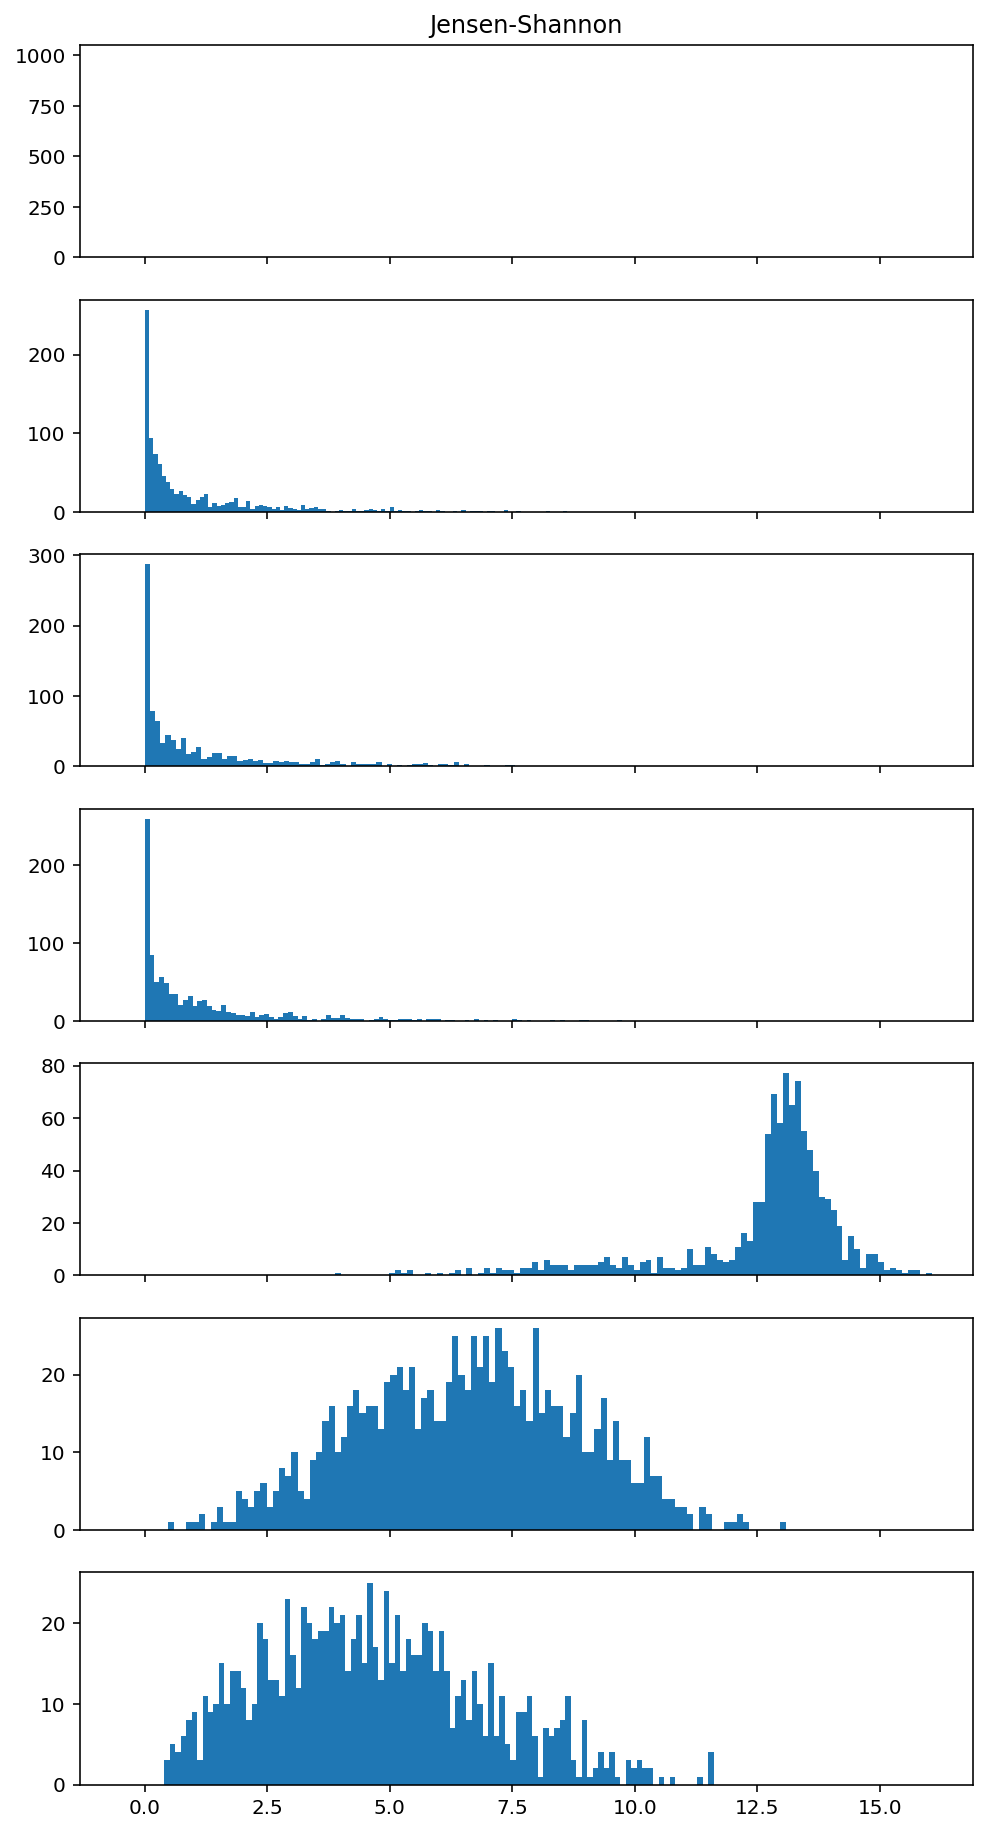

In [29]:
_ = Plotting.compare_mixture_weights(posterior, model)

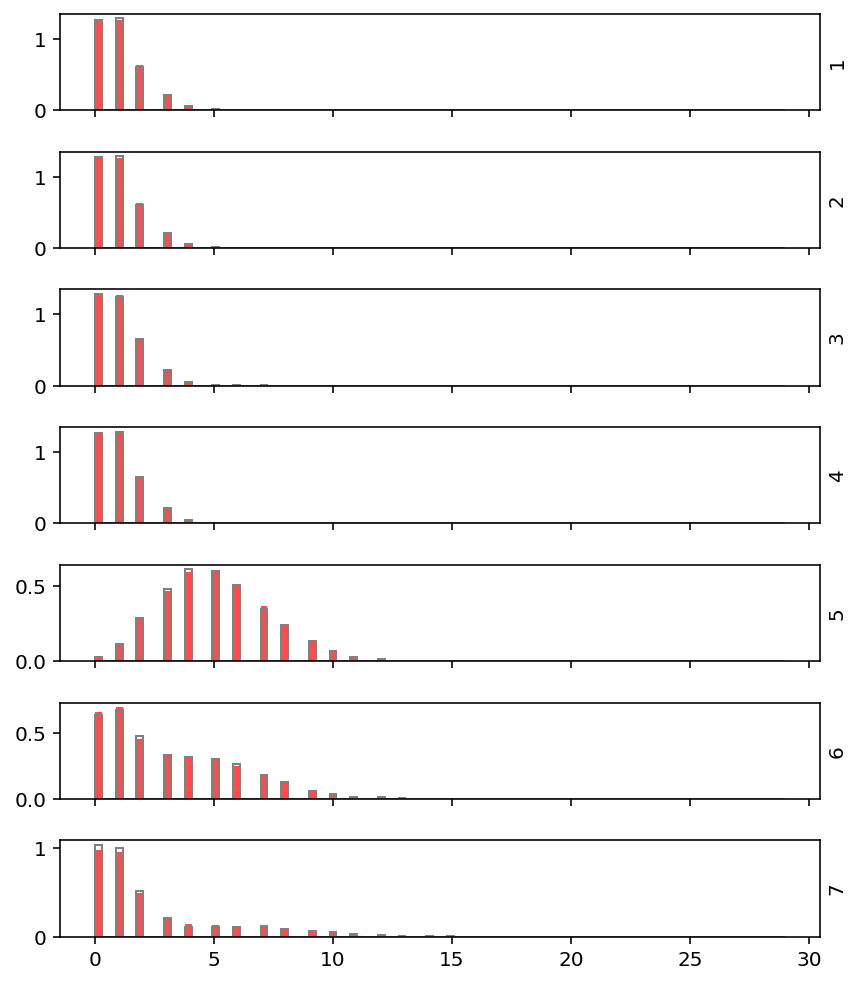

In [30]:
_ = Plotting.obs(groups, posterior['obs'])

# Expected Divergence from a Reference 

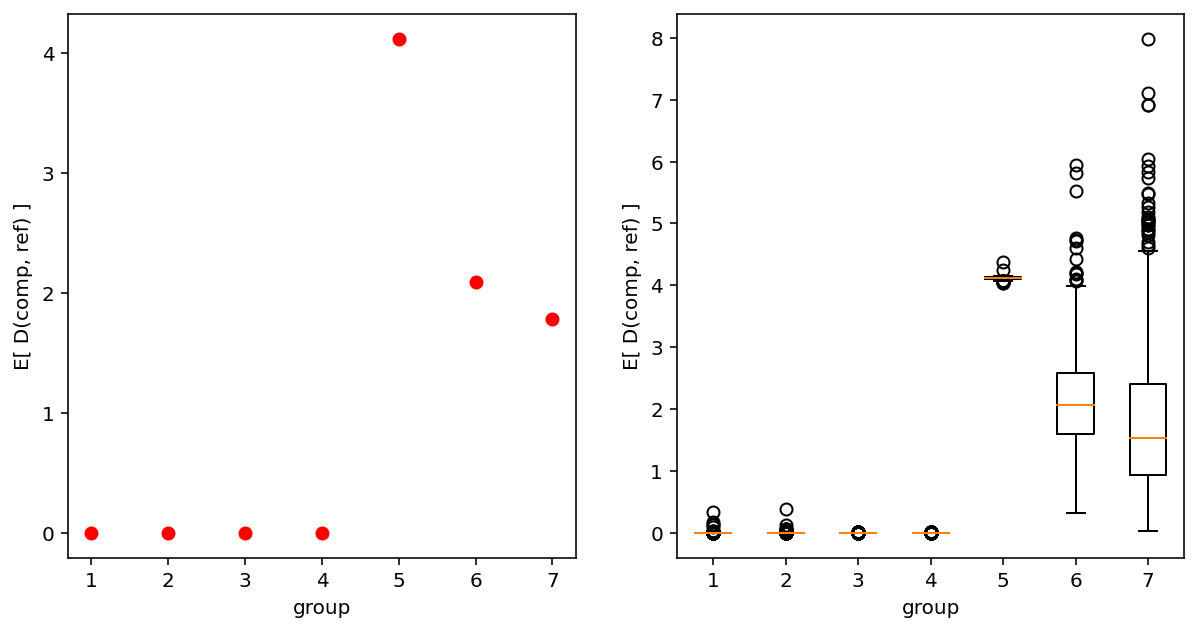

In [31]:
if example == 'poisson':
    p_from = td.Poisson(torch.ones(1, device=model.device))
else:
    p_from = td.Normal(torch.zeros(1, device=model.device), torch.ones(1, device=model.device))
    
_ = Plotting.expected_divergence(p_from, posterior, model, D=td.kl_divergence)

Ideally, the first 4 groups should have divergence close to 0 in the plots above.